
# Week 2 — Baseline Prediction Models & Evaluation

In this notebook, you will build **baseline prediction models** for financial
returns and evaluate them using **strictly forward-looking (time-series)
validation**.

This week focuses on **evaluation discipline**, not on maximizing performance.


## 1. Imports

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

plt.style.use("seaborn-v0_8")



## 2. Load data from Week 1

- Reuse the data you created in Week 1.
- You can use one stock of your choice (you can repeat it for multiple stocks if you want and plot them separately)
- Take a long term horizon data set (5-10 years)


In [3]:
# TODO: load prices and returns from Week 1
import yfinance as yf
import pandas as pd

ticker = "NVDA"
start = "2015-01-01"
end = "2025-01-01"

df = yf.download(ticker, start=start, end=end, progress=False)

# Robust price selection
if "Adj Close" in df.columns:
    prices = df["Adj Close"]
else:
    prices = df["Close"]

prices = prices.dropna()
prices.head()

/var/folders/g0/7bxbysvn2t14r0shxdztp7dm0000gn/T/ipykernel_2733/2476796065.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


Ticker,NVDA
Date,
2015-01-02,0.483011
2015-01-05,0.474853
2015-01-06,0.460456
2015-01-07,0.459257
2015-01-08,0.476533



## 3. Feature construction

Required features:
- $r_t$
- $r_{t-1}$
- 20-day rolling mean
- 20-day rolling volatility
- 5-day momentum


In [4]:

# TODO: construct features using only past data
import numpy as np
import pandas as pd

# 1. Log returns
returns = np.log(prices / prices.shift(1))

# 2. Feature DataFrame
features = pd.DataFrame(index=prices.index)

# r_t
features["r_t"] = returns

# r_{t-1}
features["r_t-1"] = returns.shift(1)

# 20-day rolling mean of returns
features["rolling_mean_20"] = returns.rolling(window=20).mean()

# 20-day rolling volatility (std dev)
features["rolling_vol_20"] = returns.rolling(window=20).std()

# 5-day momentum (log-price difference)
features["momentum_5"] = np.log(prices / prices.shift(5))

# Drop rows with NaNs (due to rolling windows)
features = features.dropna()

features.head()

,r_t,r_t-1,rolling_mean_20,rolling_vol_20,momentum_5
Date,,,,,
2015-02-02,0.021639,-0.029761,-0.001283,0.020896,-0.049712
2015-02-03,0.024667,0.021639,0.000802,0.021318,0.024158
2015-02-04,0.002483,0.024667,0.002466,0.019980,0.043078
2015-02-05,0.016237,0.002483,0.003408,0.020171,0.035266
2015-02-06,-0.004402,0.016237,0.001341,0.018613,0.060624



## 4. Naive baselines


In [5]:

# TODO: zero predictor
# Target: next-day return
features["target"] = features["r_t"].shift(-1)

# Drop last row (target is NaN there)
features = features.dropna()
features["pred_zero"] = 0.0


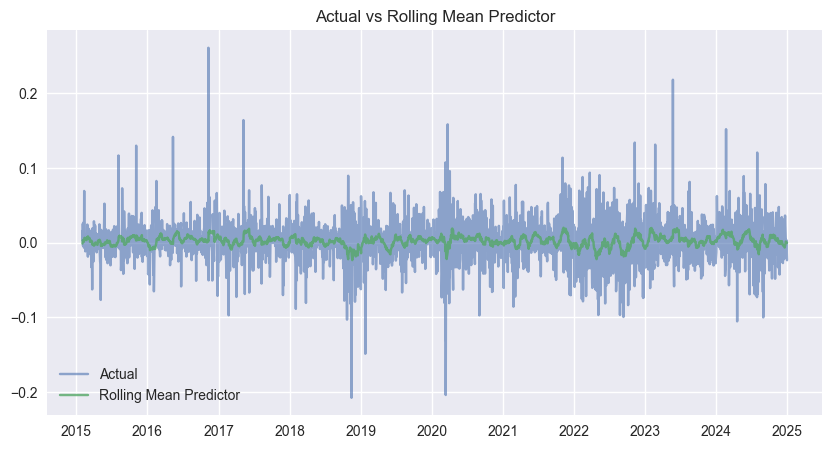

In [6]:
# TODO: rolling mean predictor
features["pred_rollmean"] = features["rolling_mean_20"]
features[[
    "r_t",
    "target",
    "pred_zero",
    "pred_rollmean"
]].head()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(features["target"], label="Actual", alpha=0.6)
plt.plot(features["pred_rollmean"], label="Rolling Mean Predictor", alpha=0.8)
plt.legend()
plt.title("Actual vs Rolling Mean Predictor")
plt.show()


0.0009693760407266013 0.0009314523976521126
0.51062124248497


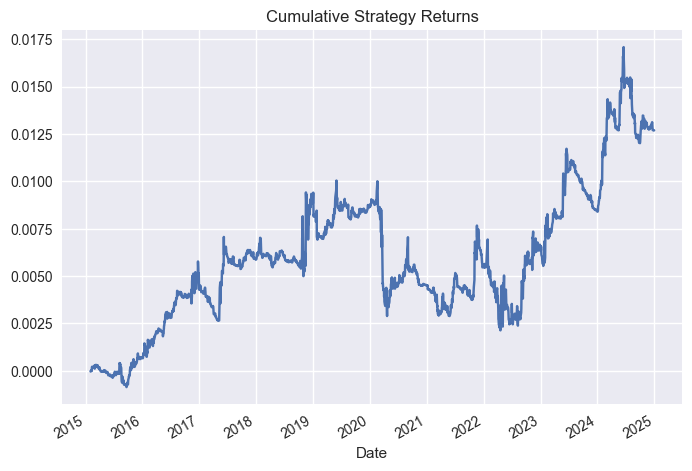

In [7]:
from sklearn.metrics import mean_squared_error

mse_roll = mean_squared_error(
    features["target"],
    features["pred_rollmean"]
)

mse_zero = mean_squared_error(
    features["target"],
    features["pred_zero"]
)

print(mse_roll, mse_zero)

directional_accuracy = (
    (features["target"] * features["pred_rollmean"]) > 0
).mean()

print(directional_accuracy)

features[["target", "pred_rollmean"]].corr()

strategy_returns = features["pred_rollmean"] * features["target"]
strategy_returns.cumsum().plot(title="Cumulative Strategy Returns")
plt.show()



## 5. Linear models (OLS & Ridge)
Suggested that you review basic linear regression theory as well (resources given in README).

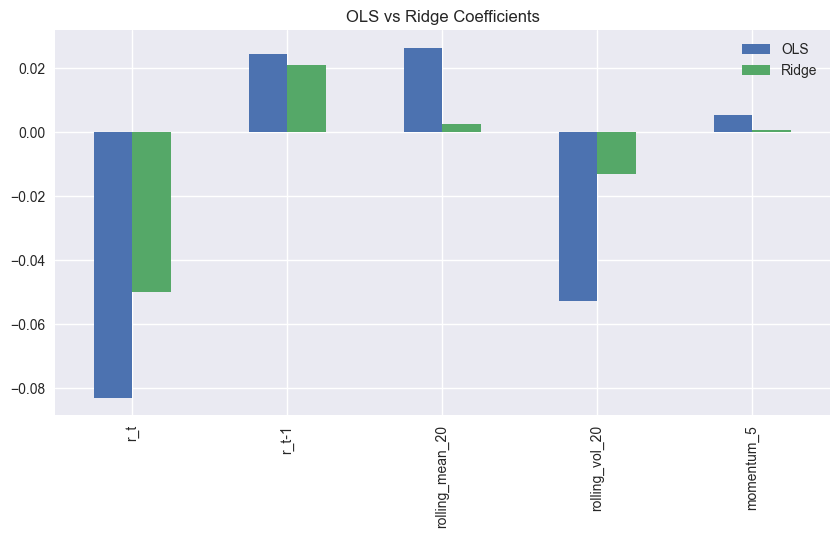

In [8]:

# use LinearRegression from sklearn
from sklearn.model_selection import train_test_split

# Feature columns
X_cols = [
    "r_t",
    "r_t-1",
    "rolling_mean_20",
    "rolling_vol_20",
    "momentum_5"
]

X = features[X_cols]
y = features["target"]

# Time-series split (NO shuffling)
split = int(0.8 * len(features))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ols.fit(X_train, y_train)

y_pred_ols = ols.predict(X_test)

ols_coeffs = pd.Series(ols.coef_, index=X_cols)
ols_coeffs

from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)

ridge_coeffs = pd.Series(ridge.coef_, index=X_cols)
ridge_coeffs

from sklearn.metrics import mean_squared_error

mse_ols = mean_squared_error(y_test, y_pred_ols)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

mse_ols, mse_ridge

coeffs = pd.DataFrame({
    "OLS": ols_coeffs,
    "Ridge": ridge_coeffs
})

coeffs.plot(kind="bar", figsize=(10,5))
plt.title("OLS vs Ridge Coefficients")
plt.show()

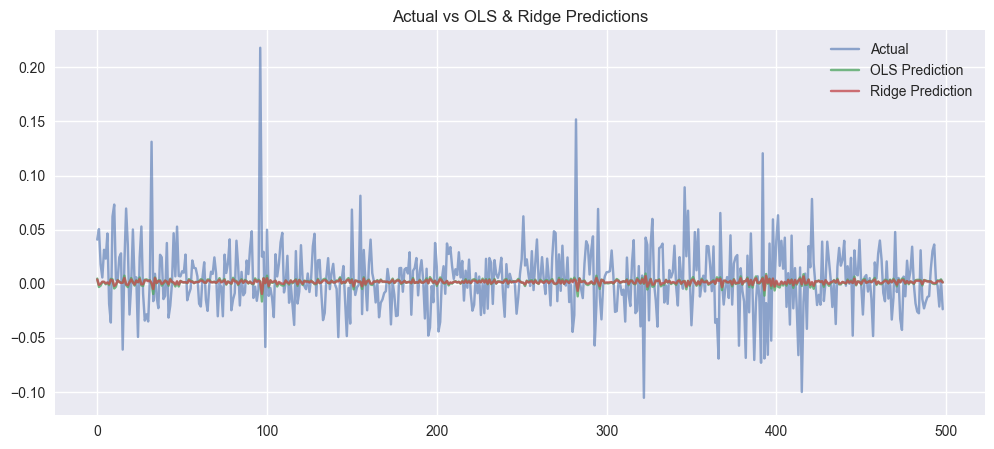

0.0009892208132909403 0.0010250847604172505 0.0009821080056870565 0.0009778400238473189
0.5130260521042084 0.5370741482965932 0.5130260521042084


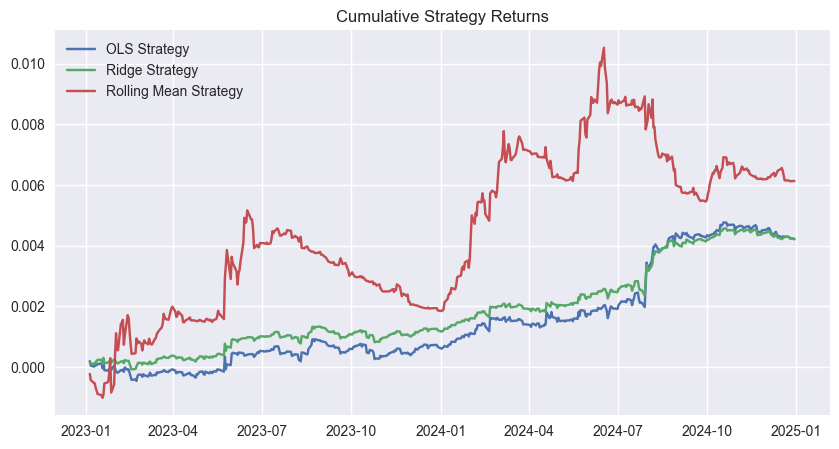

,MSE,Directional Accuracy
Zero,0.000989,0.500000
Rolling Mean,0.001025,0.513026
OLS,0.000982,0.513026
Ridge,0.000978,0.537074


In [9]:
plt.figure(figsize=(12,5))

plt.plot(y_test.values, label="Actual", alpha=0.6)
plt.plot(y_pred_ols, label="OLS Prediction", alpha=0.8)
plt.plot(y_pred_ridge, label="Ridge Prediction", alpha=0.8)

plt.legend()
plt.title("Actual vs OLS & Ridge Predictions")
plt.show()

# Zero and rolling mean baselines on test set
pred_zero_test = np.zeros_like(y_test)
pred_roll_test = features["pred_rollmean"].iloc[split:]

from sklearn.metrics import mean_squared_error

mse_zero = mean_squared_error(y_test, pred_zero_test)
mse_roll = mean_squared_error(y_test, pred_roll_test)

print(mse_zero, mse_roll, mse_ols, mse_ridge)

dir_ols = ((y_test * y_pred_ols) > 0).mean()
dir_ridge = ((y_test * y_pred_ridge) > 0).mean()
dir_roll = ((y_test * pred_roll_test) > 0).mean()

print(dir_ols, dir_ridge, dir_roll)

pd.DataFrame({
    "Actual": y_test,
    "OLS": y_pred_ols,
    "Ridge": y_pred_ridge,
    "RollingMean": pred_roll_test
}).corr()

cum_ols = (y_test * y_pred_ols).cumsum()
cum_ridge = (y_test * y_pred_ridge).cumsum()
cum_roll = (y_test * pred_roll_test).cumsum()

plt.figure(figsize=(10,5))
plt.plot(cum_ols, label="OLS Strategy")
plt.plot(cum_ridge, label="Ridge Strategy")
plt.plot(cum_roll, label="Rolling Mean Strategy")
plt.legend()
plt.title("Cumulative Strategy Returns")
plt.show()

results = pd.DataFrame({
    "MSE": [mse_zero, mse_roll, mse_ols, mse_ridge],
    "Directional Accuracy": [0.5, dir_roll, dir_ols, dir_ridge]
}, index=["Zero", "Rolling Mean", "OLS", "Ridge"])

results


## 6. Tree-based model (Random Forest) (optional)


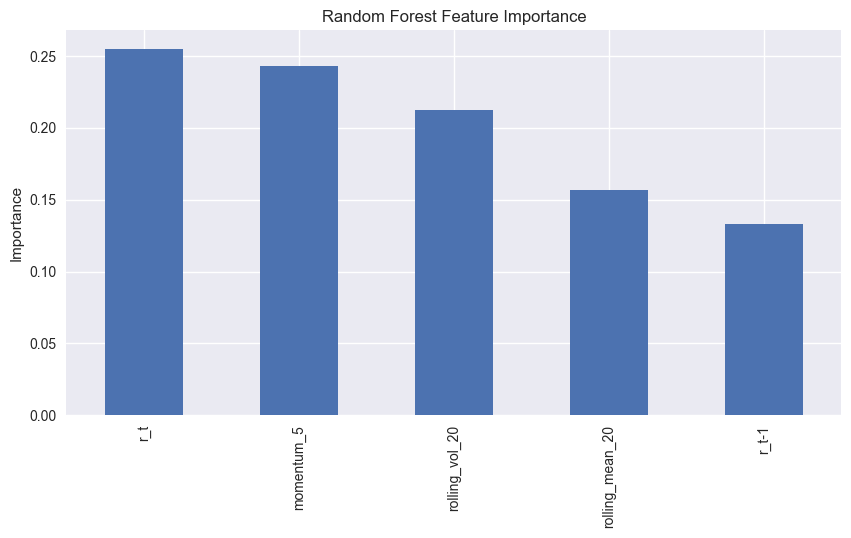

In [10]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=50,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
from sklearn.metrics import mean_squared_error

mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_rf
import pandas as pd

rf_importance = pd.Series(
    rf.feature_importances_,
    index=X_cols
).sort_values(ascending=False)

rf_importance
import matplotlib.pyplot as plt

rf_importance.plot(kind="bar", figsize=(10,5))
plt.title("Random Forest Feature Importance")
plt.ylabel("Importance")
plt.show()

## 7. Walk-forward evaluation

- Scikit reference for [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In [11]:

# TODO: implement TimeSeriesSplit evaluation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
tscv = TimeSeriesSplit(n_splits=5)

def ts_mse(model, X, y, rolling_pred=None):
    mses = []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        if model is not None:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        else:
            y_pred = rolling_pred.iloc[test_idx]

        mses.append(mean_squared_error(y_test, y_pred))
    
    return np.mean(mses)

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

ols = LinearRegression()
ridge = Ridge(alpha=1.0)
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=50,
    random_state=42
)

mse_ols   = ts_mse(ols, X, y)
mse_ridge = ts_mse(ridge, X, y)
mse_rf    = ts_mse(rf, X, y)

# Baselines
mse_zero = ts_mse(None, X, y, rolling_pred=pd.Series(0, index=y.index))
mse_roll = ts_mse(None, X, y, rolling_pred=features["pred_rollmean"])

mse_ols, mse_ridge, mse_rf, mse_zero, mse_roll

results = pd.DataFrame({
    "Model": ["Zero", "Rolling Mean", "OLS", "Ridge", "Random Forest"],
    "CV MSE": [mse_zero, mse_roll, mse_ols, mse_ridge, mse_rf]
}).set_index("Model")

results



,CV MSE
Model,
Zero,0.001024
Rolling Mean,0.001067
OLS,0.001028
Ridge,0.001021
Random Forest,0.001026



## 8. Prediction accuracy


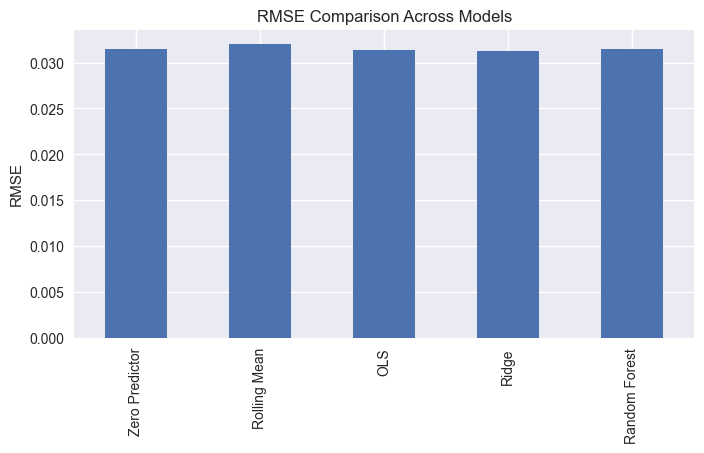

In [12]:

# TODO: compute RMSE for all models and compare them
from sklearn.metrics import mean_squared_error
import numpy as np
rmse_zero = np.sqrt(mean_squared_error(
    y_test,
    pred_zero_test
))

rmse_roll = np.sqrt(mean_squared_error(
    y_test,
    pred_roll_test
))

rmse_ols = np.sqrt(mean_squared_error(
    y_test,
    y_pred_ols
))

rmse_ridge = np.sqrt(mean_squared_error(
    y_test,
    y_pred_ridge
))

rmse_rf = np.sqrt(mean_squared_error(
    y_test,
    y_pred_rf
))
rmse_results = pd.DataFrame({
    "RMSE": [
        rmse_zero,
        rmse_roll,
        rmse_ols,
        rmse_ridge,
        rmse_rf
    ]
}, index=[
    "Zero Predictor",
    "Rolling Mean",
    "OLS",
    "Ridge",
    "Random Forest"
])

rmse_results
rmse_results.plot(
    kind="bar",
    legend=False,
    figsize=(8,4)
)
plt.ylabel("RMSE")
plt.title("RMSE Comparison Across Models")
plt.show()

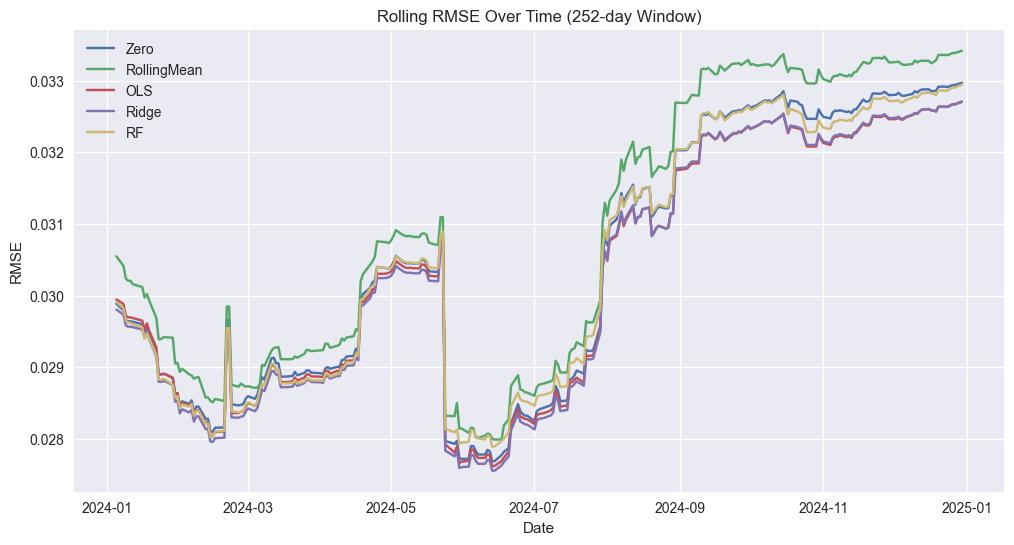

In [13]:
# TODO: plot rolling RMSE vs time for all models to compare their performance across different time periods/regimes
window = 252  # ~1 trading year
def rolling_rmse(y_true, y_pred, window):
    return (
        (y_true - y_pred)
        .rolling(window)
        .apply(lambda x: np.sqrt(np.mean(x**2)), raw=False)
    )
preds = pd.DataFrame({
    "Actual": y_test,
    "Zero": pred_zero_test,
    "RollingMean": pred_roll_test,
    "OLS": y_pred_ols,
    "Ridge": y_pred_ridge,
    "RF": y_pred_rf
}, index=y_test.index)
rolling_rmse_df = pd.DataFrame(index=preds.index)

for col in preds.columns[1:]:
    rolling_rmse_df[col] = rolling_rmse(
        preds["Actual"],
        preds[col],
        window
    )
plt.figure(figsize=(12,6))

for col in rolling_rmse_df.columns:
    plt.plot(rolling_rmse_df[col], label=col)

plt.legend()
plt.title("Rolling RMSE Over Time (252-day Window)")
plt.ylabel("RMSE")
plt.xlabel("Date")
plt.show()


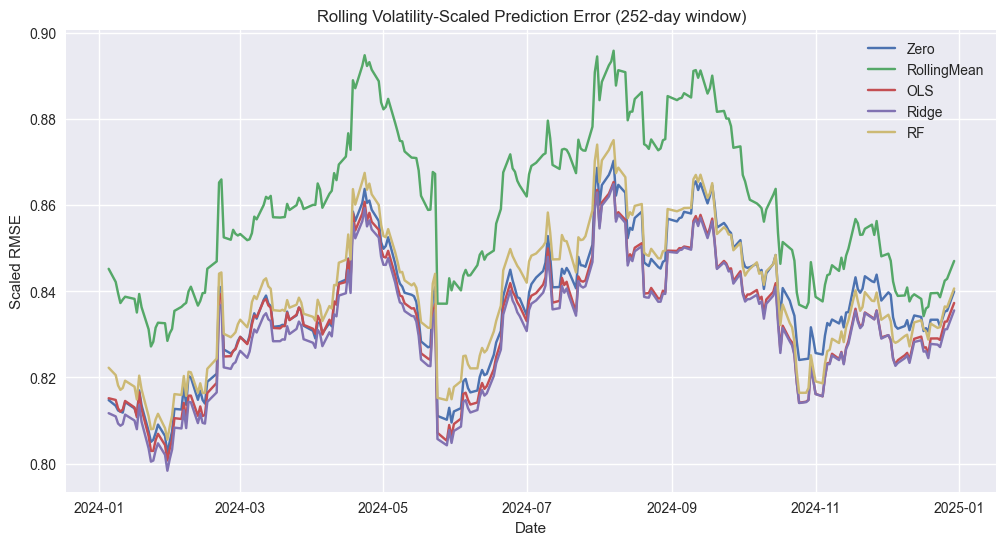

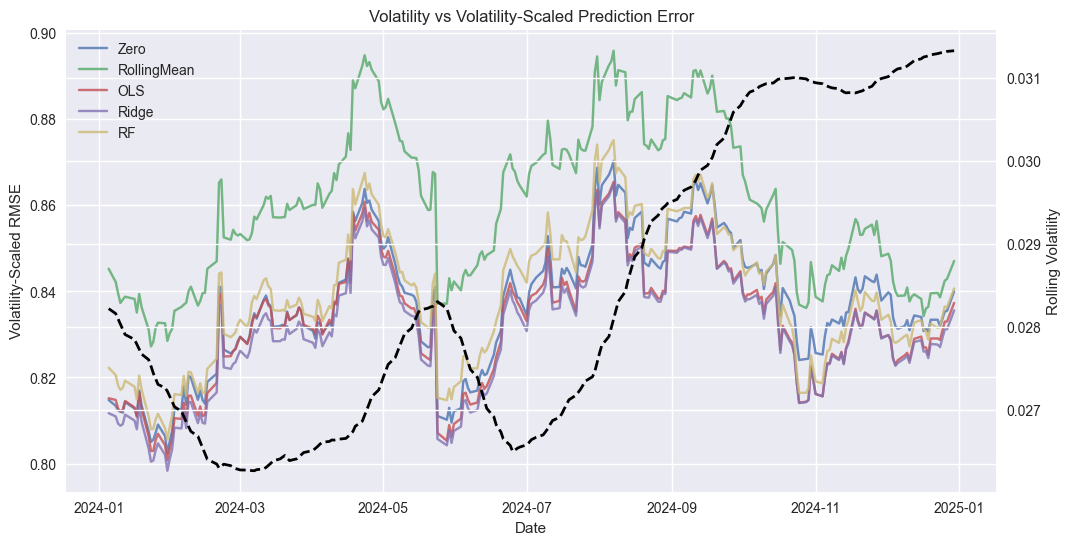

In [19]:
# Bonus: compute volatility scaled/normalized prediction error: sqrt( ((y_true - y_pred)**2) / (vol_t**2) ) - and compare across models
vol_test = features["rolling_vol_20"].iloc[split:]
def vol_scaled_error(y_true, y_pred, vol):
    return np.sqrt(((y_true - y_pred) ** 2) / (vol ** 2))
scaled_errors = pd.DataFrame({
    "Zero": vol_scaled_error(y_test, pred_zero_test, vol_test),
    "RollingMean": vol_scaled_error(y_test, pred_roll_test, vol_test),
    "OLS": vol_scaled_error(y_test, y_pred_ols, vol_test),
    "Ridge": vol_scaled_error(y_test, y_pred_ridge, vol_test),
    "RF": vol_scaled_error(y_test, y_pred_rf, vol_test)
}, index=y_test.index)
scaled_errors.mean().sort_values()
window = 252  # 1 year

rolling_scaled_rmse = scaled_errors.rolling(window).mean()
plt.figure(figsize=(12,6))

for col in rolling_scaled_rmse.columns:
    plt.plot(rolling_scaled_rmse[col], label=col)

plt.legend()
plt.title("Rolling Volatility-Scaled Prediction Error (252-day window)")
plt.ylabel("Scaled RMSE")
plt.xlabel("Date")
plt.show()

rolling_vol_test = vol_test.rolling(window).mean()

fig, ax1 = plt.subplots(figsize=(12,6))

# Plot rolling scaled RMSE (left axis)
for col in rolling_scaled_rmse.columns:
    ax1.plot(
        rolling_scaled_rmse.index,
        rolling_scaled_rmse[col],
        label=col,
        alpha=0.8
    )

ax1.set_ylabel("Volatility-Scaled RMSE")
ax1.set_xlabel("Date")
ax1.legend(loc="upper left")

# Plot volatility (right axis)
ax2 = ax1.twinx()
ax2.plot(
    rolling_vol_test.index,
    rolling_vol_test,
    color="black",
    linestyle="--",
    linewidth=2,
    label="Rolling Volatility"
)
ax2.set_ylabel("Rolling Volatility")

plt.title("Volatility vs Volatility-Scaled Prediction Error")
plt.show()


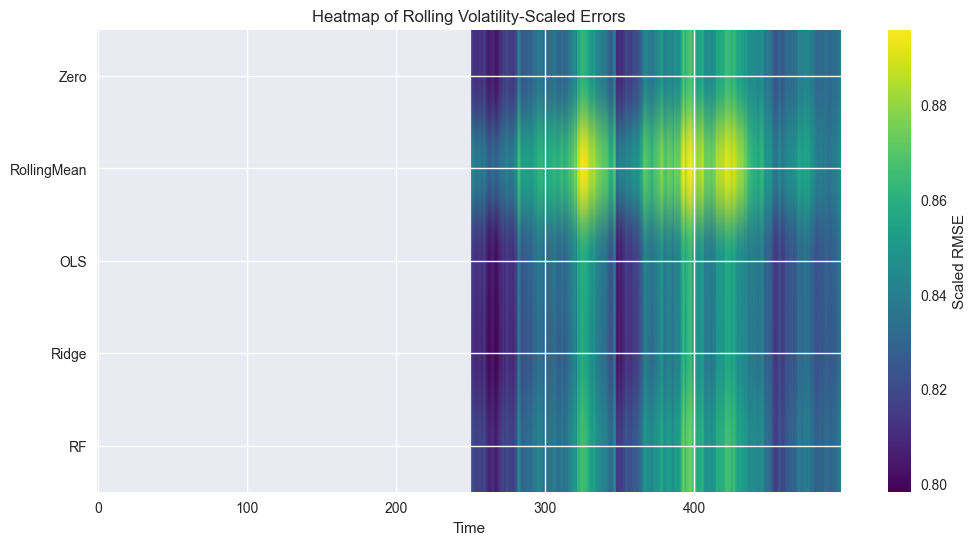

In [20]:
plt.figure(figsize=(12,6))
plt.imshow(
    rolling_scaled_rmse.T,
    aspect="auto",
    cmap="viridis"
)
plt.colorbar(label="Scaled RMSE")
plt.yticks(
    range(len(rolling_scaled_rmse.columns)),
    rolling_scaled_rmse.columns
)
plt.title("Heatmap of Rolling Volatility-Scaled Errors")
plt.xlabel("Time")
plt.show()

## 9. Bonus: Looking at a toy strategy based on predictions
Define a simple "all-in" strategy where you go all long (+1) when you predict the stock to be going up, and all short (-1) when you predict the stock to be going down
$$
\text{position}_t = \text{sign}(y_\text{pred})
$$
Then, your returns for the $t$-th day (assuming daily returns) will be $(\text{position}_t \times y_\text{true})$ (note $y_\text{true} = r_t$).

Note that this is extremely simplistic and ignore any predictions related magnitude of expected returns, or expected volatility data etc. It is used only as a demonstration of what a prediction-based strategy may look like.

**Plot your returns using this strategy based on all the models above and compare them!**

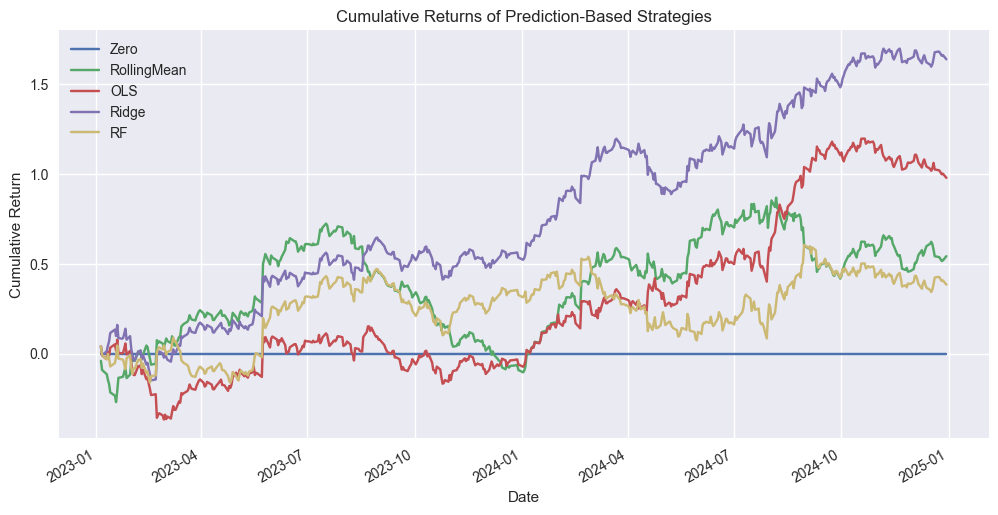

In [17]:
# TODO: compute the positions for each model and daily returns
import numpy as np

def compute_positions(y_pred):
    return np.sign(y_pred)
def compute_strategy_returns(y_true, y_pred):
    positions = compute_positions(y_pred)
    return positions * y_true
positions = pd.DataFrame({
    "Zero": compute_positions(pred_zero_test),
    "RollingMean": compute_positions(pred_roll_test),
    "OLS": compute_positions(y_pred_ols),
    "Ridge": compute_positions(y_pred_ridge),
    "RF": compute_positions(y_pred_rf)
}, index=y_test.index)
daily_returns = pd.DataFrame({
    "Zero": compute_strategy_returns(y_test, pred_zero_test),
    "RollingMean": compute_strategy_returns(y_test, pred_roll_test),
    "OLS": compute_strategy_returns(y_test, y_pred_ols),
    "Ridge": compute_strategy_returns(y_test, y_pred_ridge),
    "RF": compute_strategy_returns(y_test, y_pred_rf)
}, index=y_test.index)
positions.head(), daily_returns.head()
cumulative_returns = daily_returns.cumsum()

cumulative_returns.plot(figsize=(12,6))
plt.title("Cumulative Returns of Prediction-Based Strategies")
plt.ylabel("Cumulative Return")
plt.show()

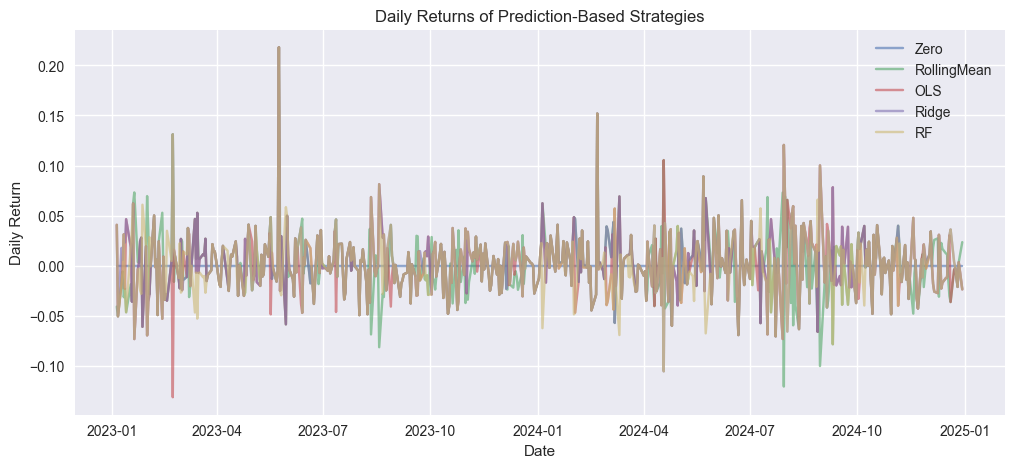

In [18]:
# TODO: plot your returns
plt.figure(figsize=(12,5))

for col in daily_returns.columns:
    plt.plot(daily_returns[col], alpha=0.6, label=col)

plt.legend()
plt.title("Daily Returns of Prediction-Based Strategies")
plt.ylabel("Daily Return")
plt.xlabel("Date")
plt.show()


## 10. Discussion questions

1. Why do we need naive baselines?
2. How does the evaluation strategy here (walk-forward evaluation) differ from the random training-test dataset splits used in convention ML?
3. *(Addon)* And, why does random splitting technique fail here?
4. Interpret the RMSE values and rolling RMSE plot results very briefly.
5. *(Addon)* Are there periods where model performance degrades noticeably? What might this indicate?
6. Why might Random Forest overfit?
7. *(Bonus)* Two models have similar RMSE, but one makes larger errors primarily during high-volatility periods. Why might this model be *less dangerous* in a portfolio context?

## 11. Answers

1. Naive baselines are a good way to check whether a model is better than just predicting 0 as the return, if this is the case, then the model is of very little use, and needs to be checked for the source of such an observation.
2. In this case, we are not having the trading data of the future dates, so the walk-forward evaluation is a good choice that achieves this. 
3. Randomly splitting into test-train datasets allows the model to have data from the future.
4. The rolling RMSE plots are a bit random, being high in some regions and lower in some other regions.
5. The model rmse values seem to increase when the volatility increases, this indicates that the market dynamics change over time and a model trained on more calm periods may struggle during high volatility period.
6. Random forest might have overfit since it is a good algorithm capable of capturing noise, especially with deeper trees, leading to overfitting.
7. Errors during high volatility are expected since the behaviour can be very random/ volatile. A model which fails with normal periods would be slightly worse in general.